In [1]:
import os
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.models import Sequential
from keras.models import load_model
from keras.applications import MobileNet
from keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
batch_size = 32
dataset_code = 'B'
model_name = 'MobileNet_(20)'
data_saved_dir = r'D:\My Code\Classification\pickle_data'
# model_saved_dir = r'D:\My Code\Classification\models'
model_saved_dir = r'F:\models'
train_data_path = f'{data_saved_dir}\B_augmented(20)_training.pkl'
val_data_path = f'{data_saved_dir}\B_validation.pkl'
test_data_path = f'{data_saved_dir}\B_testing.pkl'

In [3]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

train_images, train_labels = load_pickle(train_data_path)
val_images, val_labels = load_pickle(val_data_path)
test_images, test_labels = load_pickle(test_data_path)

print(f'Training images: {train_images.shape}')
print(f'Validation images: {val_images.shape}')
print(f'Testing images: {test_images.shape}')

Training images: (6656, 256, 256, 3)
Validation images: (979, 256, 256, 3)
Testing images: (990, 256, 256, 3)


In [4]:
class CustomDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.images))

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_images = self.images[start:end]
        batch_labels = self.labels[start:end]
        return batch_images, batch_labels

train_data_generator = CustomDataGenerator(train_images, train_labels, batch_size)
val_data_generator = CustomDataGenerator(val_images, val_labels, batch_size)
test_data_generator = CustomDataGenerator(test_images, test_labels, batch_size)

In [5]:
mobile_net = MobileNet(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

model = Sequential()
model.add(mobile_net)

for layer in model.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(units=2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 2048)              134219776 
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 137,450,689
Trainable params: 134,221,825
Non-trainable params: 3,228,864
__________________________________

In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

model_dir = f'{model_saved_dir}\{dataset_code}_{model_name}'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
else:
    print(f'{model_dir} already exists')

filename = 'weights-improvement-{epoch:02d}-{val_accuracy:.2f}'
filepath = f'{model_dir}\{dataset_code}_{model_name}-{filename}.hdf5'
 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

callbacks_list = [checkpoint, early_stop]

In [7]:
history = model.fit(train_data_generator, epochs=50, validation_data=val_data_generator, callbacks = callbacks_list)

Epoch 1/50
207/208 [============================>.] - ETA: 0s - loss: 3.4514 - accuracy: 0.8505
Epoch 1: val_accuracy improved from -inf to 0.87334, saving model to F:\models\B_MobileNet_(20)\B_MobileNet_(20)-weights-improvement-01-0.87.hdf5
208/208 [==============================] - 17s 68ms/step - loss: 3.4366 - accuracy: 0.8508 - val_loss: 0.3608 - val_accuracy: 0.8733
Epoch 2/50
207/208 [============================>.] - ETA: 0s - loss: 0.1366 - accuracy: 0.9490
Epoch 2: val_accuracy improved from 0.87334 to 0.89990, saving model to F:\models\B_MobileNet_(20)\B_MobileNet_(20)-weights-improvement-02-0.90.hdf5
208/208 [==============================] - 14s 65ms/step - loss: 0.1364 - accuracy: 0.9491 - val_loss: 0.3234 - val_accuracy: 0.8999
Epoch 3/50
207/208 [============================>.] - ETA: 0s - loss: 0.0598 - accuracy: 0.9777
Epoch 3: val_accuracy improved from 0.89990 to 0.92441, saving model to F:\models\B_MobileNet_(20)\B_MobileNet_(20)-weights-improvement-03-0.92.hdf5
20

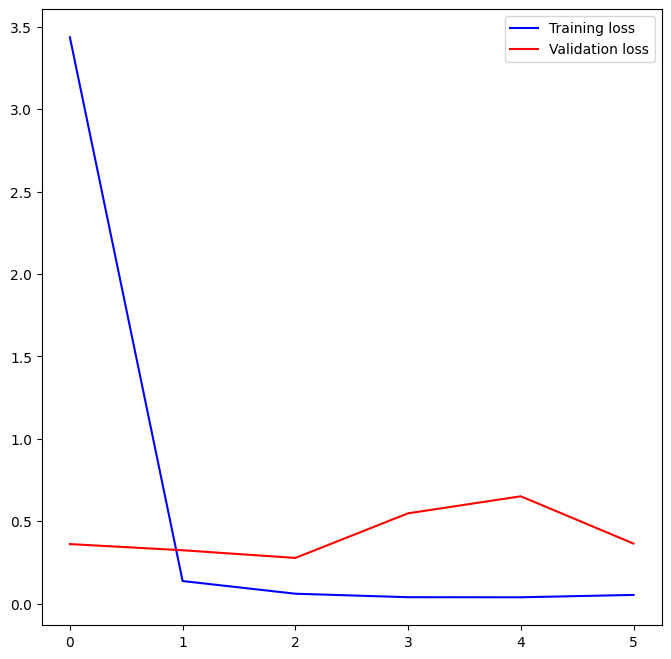

<Figure size 640x480 with 0 Axes>

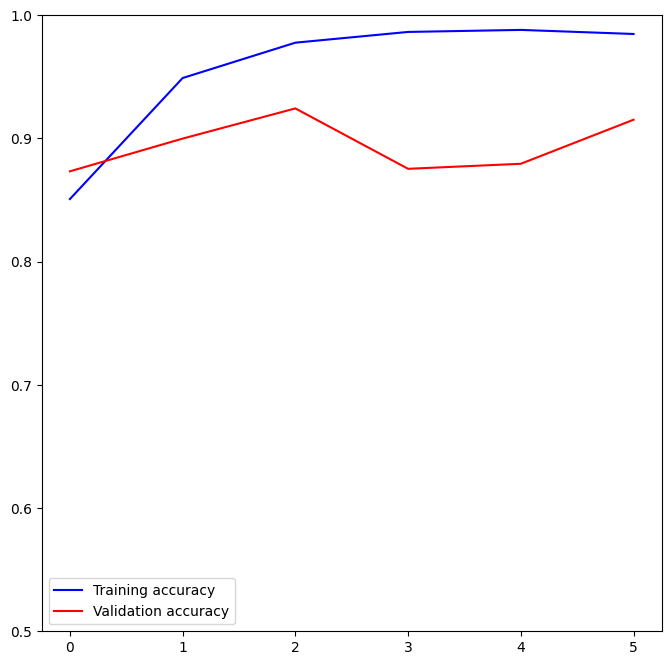

In [8]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.ylim(0.5, 1)
plt.show()

#### Testing on model till Last Epoch

31/31 [==============================] - 2s 36ms/step


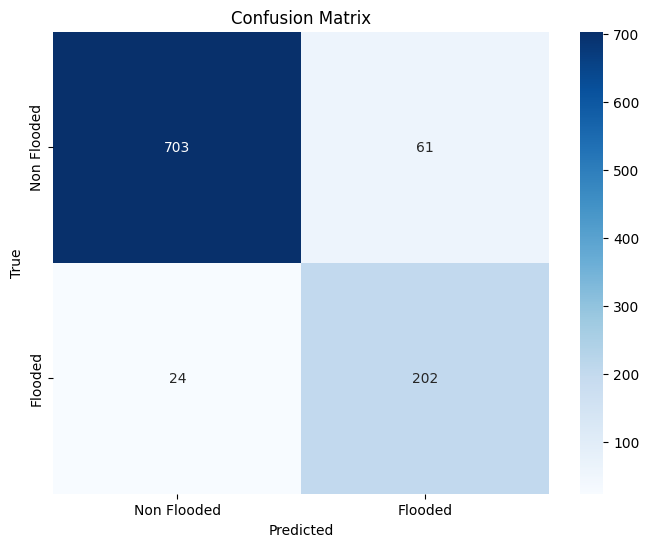

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       764
           1       0.77      0.89      0.83       226

    accuracy                           0.91       990
   macro avg       0.87      0.91      0.88       990
weighted avg       0.92      0.91      0.92       990



In [9]:
predictions = model.predict(test_data_generator)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

#### Testing on model which is last best saved

['B_MobileNet_(20)-weights-improvement-03-0.92.hdf5']
Best model loaded ...
31/31 [==============================] - 2s 36ms/step


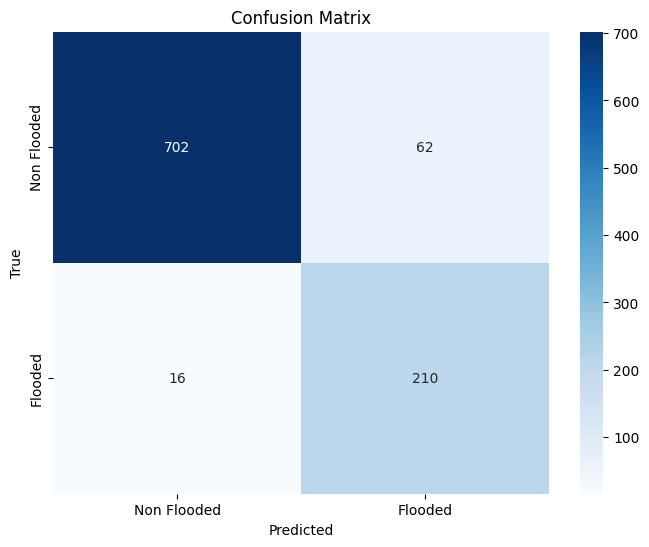

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       764
           1       0.77      0.93      0.84       226

    accuracy                           0.92       990
   macro avg       0.87      0.92      0.90       990
weighted avg       0.93      0.92      0.92       990



In [10]:
model_dir = f'{model_saved_dir}\{dataset_code}_{model_name}'

models = sorted(os.listdir(model_dir))

for file in models[:-1]:
    os.remove(f'{model_dir}\{file}')

print(os.listdir(model_dir))
best_model = load_model(f'{model_dir}\{models[-1]}')
print('Best model loaded ...')

predictions = best_model.predict(test_data_generator)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))